In [2]:
from google.colab import drive

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil




In [5]:
%config IPCompleter.greedy=True

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sn
import re
import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree,preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import normalize
from imblearn.over_sampling import RandomOverSampler
from pandas.plotting import parallel_coordinates,scatter_matrix
from collections import Counter

# Load our data

In [7]:
def parse_file_train(filename):
    line = list()
    with open(filename) as f:
        lines = f.readline()
        counter = 1
        while lines:
            data = lines.strip('\n').split(',')
            actions = data[2:]
            player = data[0]
            race= data[1]
            line.append([player,race,actions])
            lines = f.readline()
            counter += 1
    return line


def parse_file_test(filename):
    line = list()
    with open(filename) as f:
        lines = f.readline()
        counter = 1
        while lines:
            data = lines.strip('\n').split(',')
            actions = data[1:]
            race = data[0]
            line.append([race,actions])
            lines = f.readline()
            counter += 1
    return line

In [8]:
train = parse_file_train('/content/drive/MyDrive/Colab Notebooks/post-4834-TRAIN_1.CSV')
test=parse_file_test('/content/drive/MyDrive/Colab Notebooks/TEST.CSV')

In [9]:
print("La shape du jeu d'entrainement est " + str(len(train)))
print("La shape du jeu de test est " + str(len(test)))

La shape du jeu d'entrainement est 3052
La shape du jeu de test est 340


In [10]:
def count_freq(line):
    player, race, actions = line
    counter = []
    c=0
    c1=0
    c2=0
    j='t0'
    tmp=0
    t0=0
    t_max=t_min=0
    matching = [s for s in actions if s.startswith('t')]
    for j in matching:
        index = actions.index(j)
        hot= 's'
        c+=actions[t0:index].count(hot)
        hot='Base'
        c+=actions[t0:index].count(hot)
        hot='SingleMineral'
        c+=actions[t0:index].count(hot)
        for i in range(10):
            hot = 'hotkey'+str(i)+'0'
            c+=actions[t0:index].count(hot)
            hot = 'hotkey'+str(i)+'1'
            c+=actions[t0:index].count(hot)
            hot = 'hotkey'+str(i)+'2'
            c+=actions[t0:index].count(hot)
        if(tmp<c):
            tmp=c
            t_max=index
            t_min=t0
        t0=index
        c=0
    t=[int(s) for s in j.split('t') if s.isdigit()]
    if(t_max and t_min and t[0]):
        tmin=t[0]/60
        for itera in range(2):
            hot='s'
            counter.append((actions.count(hot)/tmin))
            c+=actions.count(hot)
            hot='Base'
            counter.append((actions.count(hot)/tmin))
            c+=actions.count(hot)
            hot='SingleMineral'
            counter.append((actions.count(hot)/tmin))
            c+=actions.count(hot)
            for i in range(10):
                hot = 'hotkey'+str(i)+'0'
                counter.append((actions.count(hot)/tmin))
                c+=actions.count(hot)
                hot = 'hotkey'+str(i)+'1'
                counter.append((actions.count(hot)/tmin))
                c+=actions.count(hot)
                hot = 'hotkey'+str(i)+'2'
                counter.append((actions.count(hot)/tmin))
                c+=actions.count(hot)
            actions=actions[t_min:t_max]
            counter.append(c/tmin)
            c=0
    return counter

def count_freq_test(line):
    race, actions = line
    counter = []
    c=0
    c1=0
    c2=0
    j='t0'
    tmp=0
    t0=0
    t_max=t_min=0
    matching = [s for s in actions if s.startswith('t')]
    for j in matching:
        index = actions.index(j)
        hot= 's'
        c+=actions[t0:index].count(hot)
        hot='Base'
        c+=actions[t0:index].count(hot)
        hot='SingleMineral'
        c+=actions[t0:index].count(hot)
        for i in range(10):
            hot = 'hotkey'+str(i)+'0'
            c+=actions[t0:index].count(hot)
            hot = 'hotkey'+str(i)+'1'
            c+=actions[t0:index].count(hot)
            hot = 'hotkey'+str(i)+'2'
            c+=actions[t0:index].count(hot)
        if(tmp<c):
            tmp=c
            t_max=index
            t_min=t0
        t0=index
        c=0
    t=[int(s) for s in j.split('t') if s.isdigit()]
    if(t_max and t_min and t[0]):
        tmin=t[0]/60
        for itera in range(2):
            counter.append(actions.count('s')/tmin)
            c+=actions.count('s')
            counter.append(actions.count('Base')/tmin)
            c+=actions.count('Base')
            counter.append(actions.count('SingleMineral')/tmin)
            c+=actions.count('SingleMineral')
            for i in range(10):
                hot = 'hotkey'+str(i)+'0'
                counter.append(actions.count(hot)/tmin)
                c+=actions.count(hot)
                hot = 'hotkey'+str(i)+'1'
                counter.append(actions.count(hot)/tmin)
                c+=actions.count(hot)
                hot = 'hotkey'+str(i)+'2'
                counter.append(actions.count(hot)/tmin)
                c+=actions.count(hot)
            actions=actions[t_min:t_max]
            counter.append(c/tmin)
            c=0
    return counter

In [11]:
freq = list()
for line in train:
    freq.append([line[0]]+ [line[1]]+ count_freq(line))
train_dataset = pd.DataFrame(freq)

In [12]:
freq1 = list()
for line in test:
    freq1.append([line[0]]+ count_freq_test(line))
test_dataset = pd.DataFrame(freq1)

In [13]:
train_dataset.rename(columns={0:'Player',1:'Race',2:'s', 3:'Base',4:'SingleMineral',35:'TotAction',36:'mfr',37:'mfs',38:'mfb',39:'mfsm',},inplace=True)
k=5
for i in range(10):
    for j in range(3):
        train_dataset.rename(columns={k:'hotkey'+str(i)+str(j)},inplace=True)
        k+=1
k=40
for i in range(10):
    for j in range(3):
        train_dataset.rename(columns={k:'m_f_hotkey'+str(i)+str(j)},inplace=True)
        k+=1
train_dataset.head()

,Player,Race,s,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,...,m_f_hotkey62,m_f_hotkey70,m_f_hotkey71,m_f_hotkey72,m_f_hotkey80,m_f_hotkey81,m_f_hotkey82,m_f_hotkey90,m_f_hotkey91,m_f_hotkey92
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,24.435045,2.392749,0.181269,0.181269,0.0,1.486405,2.283988,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.761329
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,19.504532,0.435045,0.000000,0.072508,0.0,3.009063,2.356495,0.108761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.580060
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,25.544554,2.792079,0.178218,0.178218,0.0,1.069307,1.009901,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.188119
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,23.701493,1.253731,0.000000,0.119403,0.0,2.328358,1.910448,0.059701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.955224
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,23.111111,0.222222,0.000000,0.111111,0.0,0.000000,1.111111,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.111111


# Remarque sur les premières lignes:

On constate que pour le premier joueur par exemple: http://eu.battle.net/sc2/en/profile/4234852/1/... qui figure dans 3 premières parties (0,2,4) il s'agit de meme player mais le nombre d'actions fait par ce dernier se varie à chaque apparition dans la dataset, idem pour http://eu.battle.net/sc2/en/profile/3074362/1/... ainsi que pour chaque joueur il garde le meme race pendant tout le jeu.

In [14]:
test_dataset.rename(columns={0:'Race',1:'s', 2:'Base',3:'SingleMineral',34:'TotAction',35:'mfr',36:'mfs',37:'mfb',38:'mfsm',},inplace=True)
k=4
for i in range(10):
    for j in range(3):
        test_dataset.rename(columns={k:'hotkey'+str(i)+str(j)},inplace=True)
        k+=1
k=39
for i in range(10):
    for j in range(3):
        test_dataset.rename(columns={k:'m_f_hotkey'+str(i)+str(j)},inplace=True)
        k+=1
test_dataset.head()

,Race,s,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,...,m_f_hotkey62,m_f_hotkey70,m_f_hotkey71,m_f_hotkey72,m_f_hotkey80,m_f_hotkey81,m_f_hotkey82,m_f_hotkey90,m_f_hotkey91,m_f_hotkey92
0,Zerg,58.148571,1.302857,0.205714,0.960000,0.0,58.080000,0.480000,2.125714,24.137143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.537143
1,Terran,34.842640,0.000000,0.000000,0.121827,0.0,2.010152,0.852792,0.000000,20.467005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.253807
2,Protoss,26.959641,0.968610,0.000000,0.053812,0.0,0.000000,0.538117,0.000000,23.354260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.506726
3,Zerg,64.816327,0.693878,0.081633,0.000000,0.0,0.000000,2.775510,3.632653,21.428571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.224490
4,Protoss,21.454545,1.909091,0.000000,0.272727,0.0,0.000000,0.363636,0.636364,6.727273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.545455


In [16]:
import pandas as pd

# Check for non-numeric values in the train_dataset
non_numeric_cols = train_dataset.select_dtypes(include='object').columns.tolist()

# Print the non-numeric columns
print(f"Non-numeric columns: {non_numeric_cols}")

Non-numeric columns: ['Player', 'Race']


In [17]:
# Convert non-numeric columns to numeric
for col in non_numeric_cols:
    train_dataset[col] = pd.to_numeric(train_dataset[col], errors='coerce')

In [18]:
train_dataset=train_dataset.fillna(train_dataset.mean())
train_dataset.tail()

,Player,Race,s,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,...,m_f_hotkey62,m_f_hotkey70,m_f_hotkey71,m_f_hotkey72,m_f_hotkey80,m_f_hotkey81,m_f_hotkey82,m_f_hotkey90,m_f_hotkey91,m_f_hotkey92
3047,NaN,NaN,39.000000,0.0,0.272727,0.204545,0.0,1.227273,1.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.909091
3048,NaN,NaN,39.574468,0.0,1.480851,0.000000,0.0,0.000000,2.604255,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.195745
3049,NaN,NaN,46.153846,0.0,0.256410,0.256410,0.0,3.589744,2.974359,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.435897
3050,NaN,NaN,46.758621,0.0,4.344828,0.000000,0.0,0.000000,1.862069,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.448276
3051,NaN,NaN,40.717949,0.0,0.205128,0.102564,0.0,0.000000,1.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.974359


In [20]:
import pandas as pd

# Check for non-numeric values in the test_dataset
non_numeric_cols = test_dataset.select_dtypes(include='object').columns.tolist()

# Print the non-numeric columns
print(f"Non-numeric columns: {non_numeric_cols}")

# Convert non-numeric columns to numeric
for col in non_numeric_cols:
    test_dataset[col] = pd.to_numeric(test_dataset[col], errors='coerce')

# Fill missing values with the mean
test_dataset = test_dataset.fillna(test_dataset.mean())

# Display the last five rows of the test_dataset
test_dataset.tail()

Non-numeric columns: ['Race']


,Race,s,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,...,m_f_hotkey62,m_f_hotkey70,m_f_hotkey71,m_f_hotkey72,m_f_hotkey80,m_f_hotkey81,m_f_hotkey82,m_f_hotkey90,m_f_hotkey91,m_f_hotkey92
335,NaN,33.921260,0.000000,0.047244,0.000000,0.0,0.000000,2.692913,0.0,34.299213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.748031
336,NaN,28.650718,9.703349,0.057416,0.172249,0.0,2.296651,1.492823,0.0,28.019139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.066986
337,NaN,32.960000,0.000000,2.160000,0.000000,0.0,0.000000,1.920000,0.0,45.040000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.440000
338,NaN,29.600000,0.000000,0.200000,0.200000,0.0,0.000000,1.400000,0.0,18.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000
339,NaN,41.659091,0.000000,2.931818,0.000000,0.0,0.000000,1.840909,0.0,43.977273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.863636


In [21]:
labels=train_dataset['Player']

In [22]:
data = train_dataset.iloc[:, 2:].values

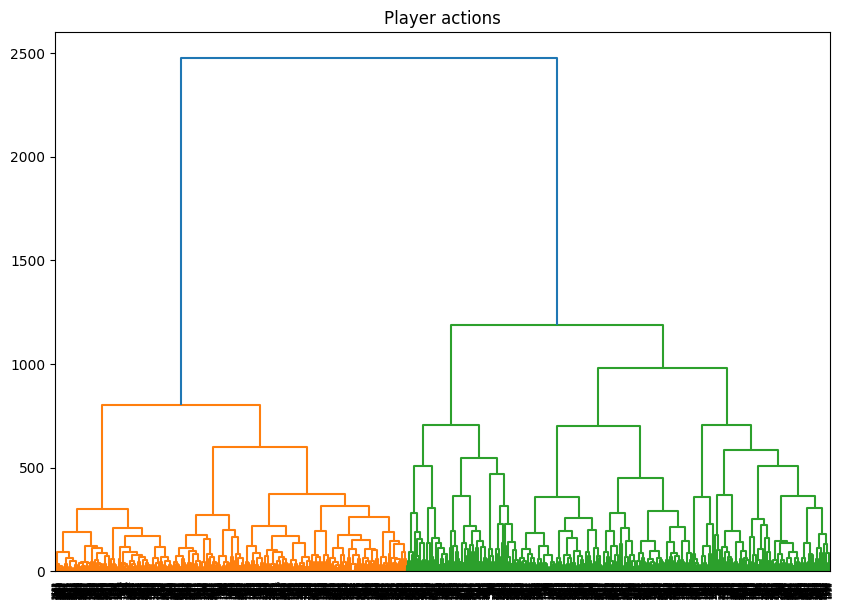

In [23]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Player actions")
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [24]:
#partie jouée par chaque jouer
players=train_dataset.groupby('Player').Player.count().reset_index(name='count').sort_values('count',ascending=False)
players.head()

,Player,count


In [25]:
max_games=players[players['count']==players['count'].min()]
l=max_games['Player'].values

In [27]:
if len(train_dataset['Player']) > 0:
    player_with_max_games= train_dataset['Player'] ==l[0]
    train_dataset[player_with_max_games]
else:
    print("The train_dataset['Player'] series is empty.")

IndexError: index 0 is out of bounds for axis 0 with size 0

In [26]:
player_with_max_games= train_dataset['Player'] ==l[0]
train_dataset[player_with_max_games]

IndexError: index 0 is out of bounds for axis 0 with size 0

array([[<Axes: title={'center': 'Player'}>,
        <Axes: title={'center': 'Race'}>, <Axes: title={'center': 's'}>,
        <Axes: title={'center': 'Base'}>,
        <Axes: title={'center': 'SingleMineral'}>,
        <Axes: title={'center': 'hotkey00'}>,
        <Axes: title={'center': 'hotkey01'}>,
        <Axes: title={'center': 'hotkey02'}>],
       [<Axes: title={'center': 'hotkey10'}>,
        <Axes: title={'center': 'hotkey11'}>,
        <Axes: title={'center': 'hotkey12'}>,
        <Axes: title={'center': 'hotkey20'}>,
        <Axes: title={'center': 'hotkey21'}>,
        <Axes: title={'center': 'hotkey22'}>,
        <Axes: title={'center': 'hotkey30'}>,
        <Axes: title={'center': 'hotkey31'}>],
       [<Axes: title={'center': 'hotkey32'}>,
        <Axes: title={'center': 'hotkey40'}>,
        <Axes: title={'center': 'hotkey41'}>,
        <Axes: title={'center': 'hotkey42'}>,
        <Axes: title={'center': 'hotkey50'}>,
        <Axes: title={'center': 'hotkey51'}>,
      

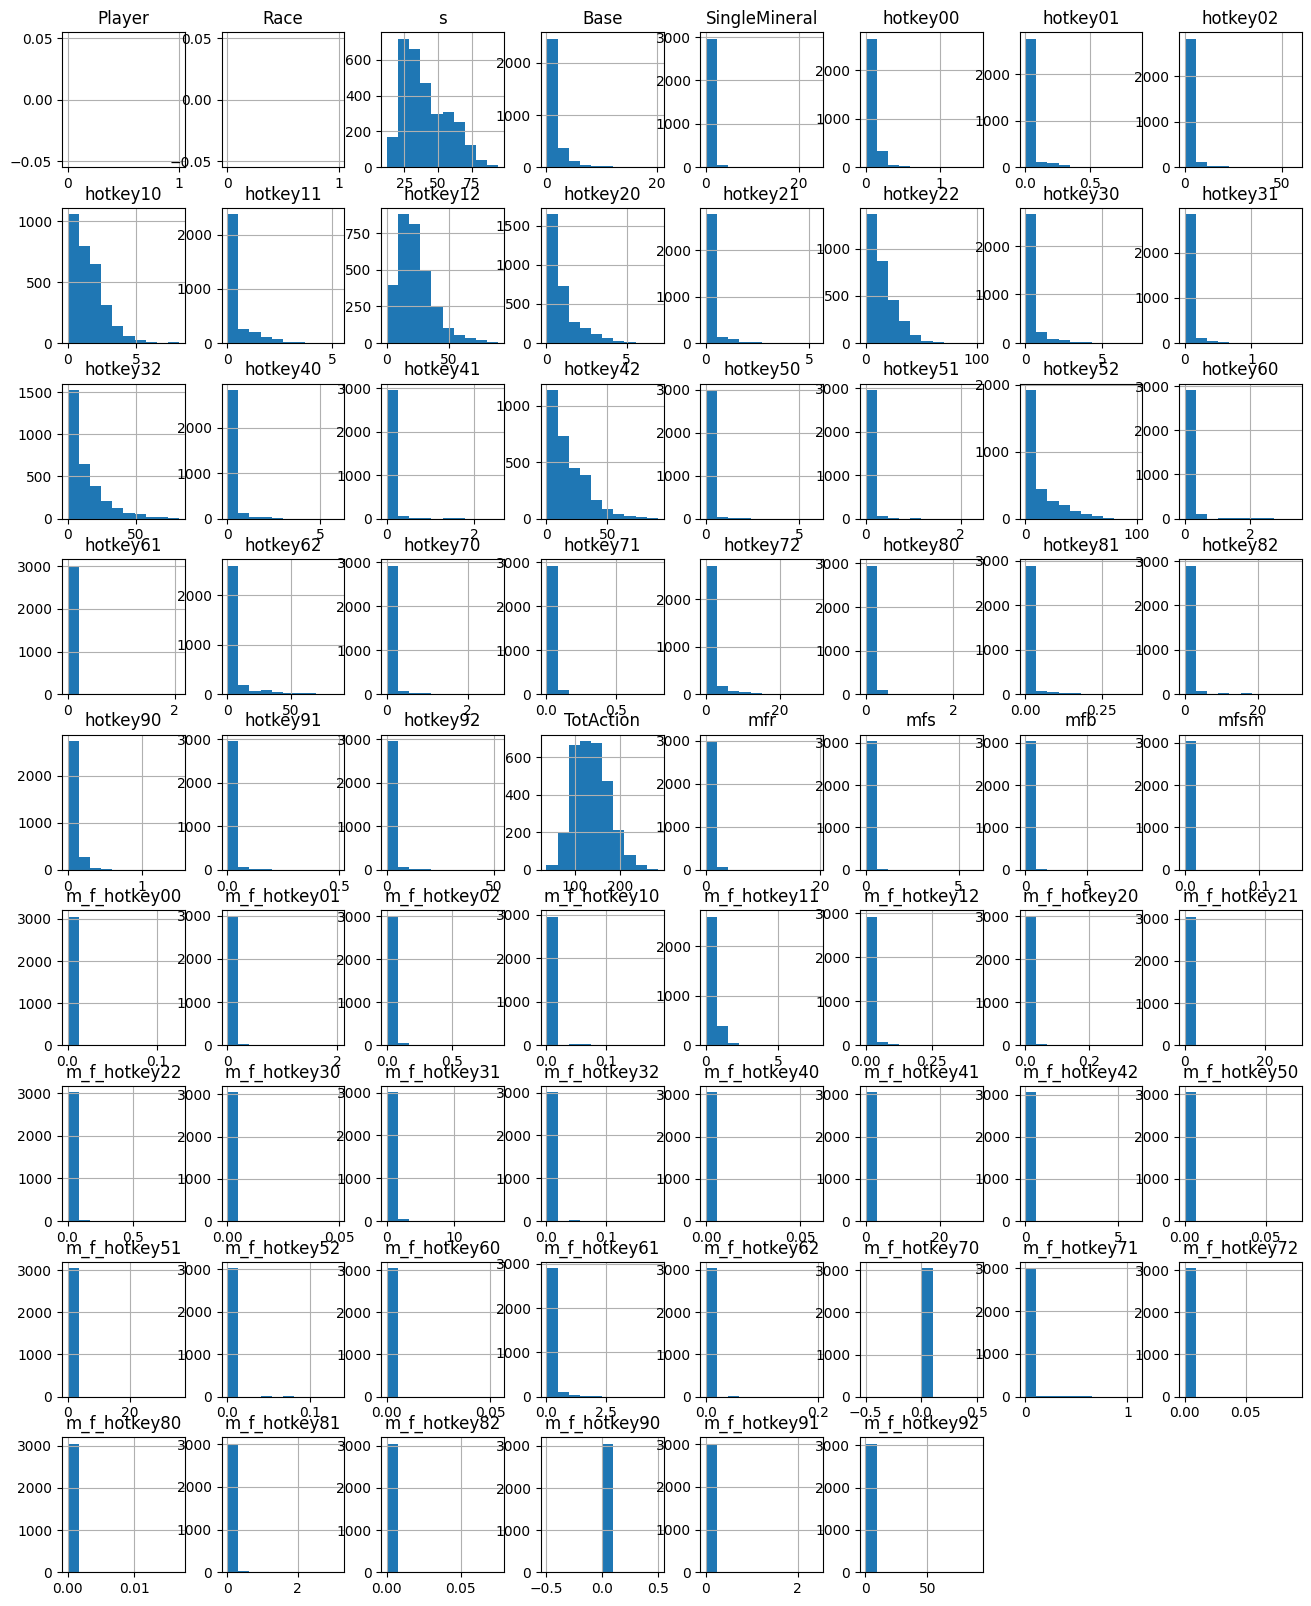

In [28]:
train_dataset.hist(figsize = (16,20), stacked= False)

In [30]:
train_dataset['Player'] = train_dataset['Player'].apply(lambda x: int(str(x).split('/')[6]) if len(str(x).split('/')) > 6 else None)


In [31]:
train_dataset.corr()['Player']

Player          NaN
Race            NaN
s               NaN
Base            NaN
SingleMineral   NaN
                 ..
m_f_hotkey81    NaN
m_f_hotkey82    NaN
m_f_hotkey90    NaN
m_f_hotkey91    NaN
m_f_hotkey92    NaN
Name: Player, Length: 70, dtype: float64

In [35]:
#on essaye de se débarasser des données qui sont pas corrélées
serie = pd.Series(train_dataset.corr()['Player'])
# Option 2: Remove the line that attempts to remove the 'Player' element

attributs = list(serie[abs(serie) > 0.01].index)
attributs.append('Race')
attributs.append('Player')
attributs

['Race', 'Player']

<Axes: >

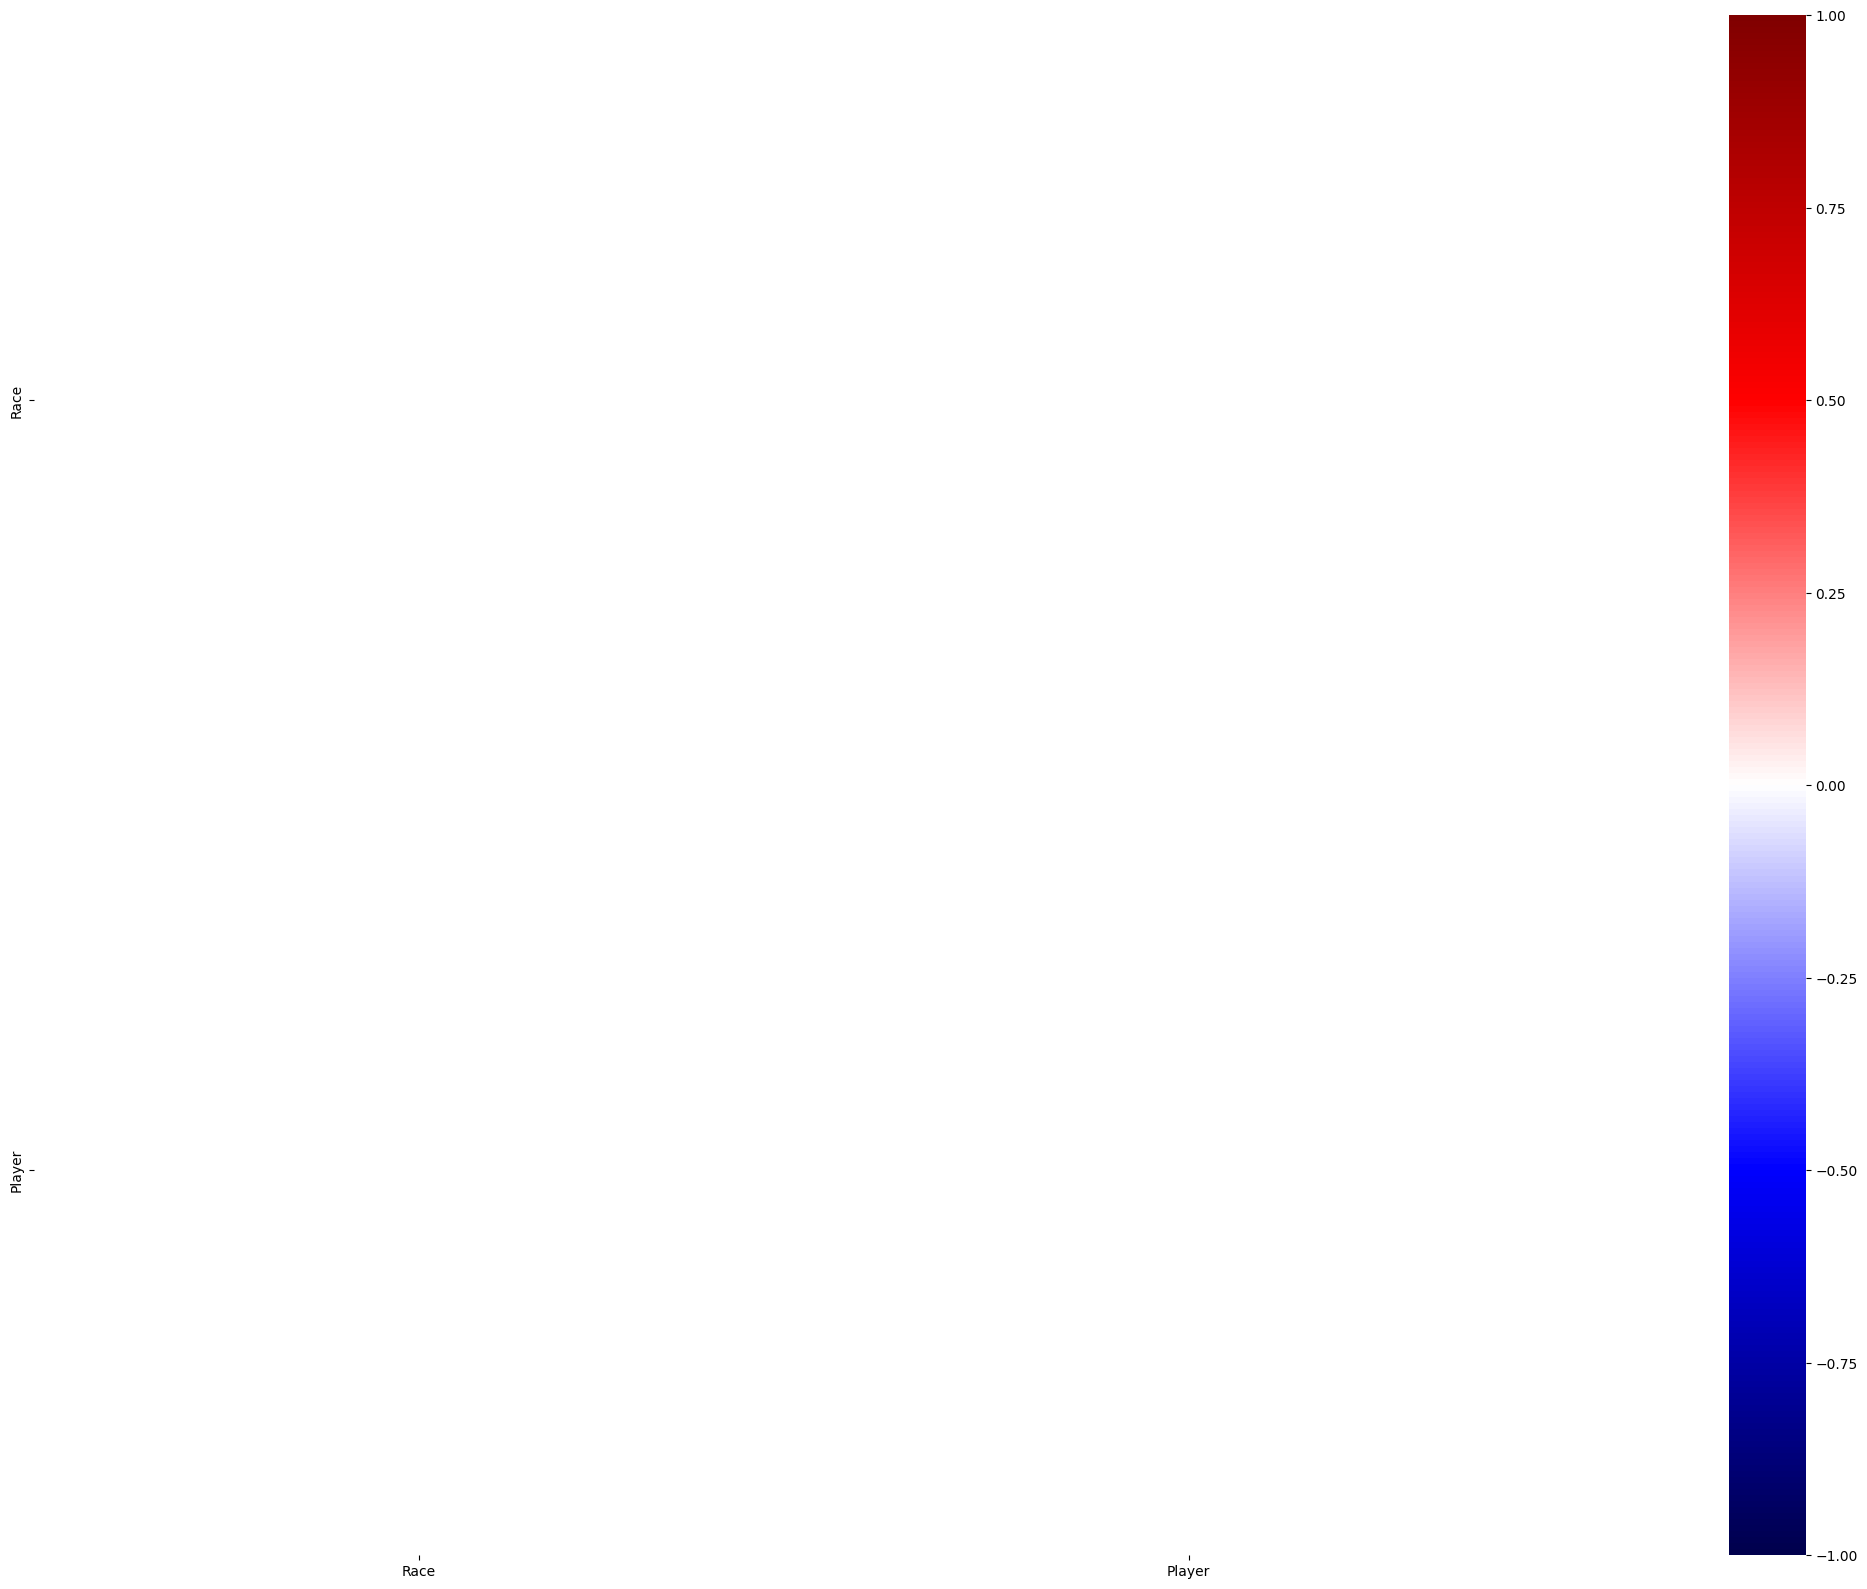

In [36]:
corrMatt = train_dataset[attributs].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(40,20)
sn.heatmap(corrMatt, center = 0 ,cmap = "seismic",vmin=-1, vmax=1, square=True,annot=False)

In [40]:
# Encodage
label_encoder = preprocessing.LabelEncoder()
enc.fit(['Terran','Protoss','Zerg'])
test_dataset = test_dataset.dropna(subset=['Race'])
train_dataset = train_dataset.dropna(subset=['Race'])
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train_dataset['Race'].unique())
test_dataset['Race'] = label_encoder.transform(test_dataset['Race'])
train_dataset['Race'] = label_encoder.transform(train_dataset['Race'])
enc = preprocessing.LabelEncoder()
label_encoder.fit(train_dataset['Race'].unique())
test_dataset['Race'] = label_encoder.transform(test_dataset['Race'])
train_dataset['Race'] = label_encoder.transform(train_dataset['Race'])

In [43]:
features =  train_dataset.loc[:, train_dataset.columns != 'Player']
features=pd.DataFrame(features)
print(len(features))
print(len(labels))
#split la data pour le training et le testing
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=43, shuffle=False)


0
3052


ValueError: Found input variables with inconsistent numbers of samples: [0, 3052]

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Extract labels
labels = train_dataset['Player']

# Extract features
features = train_dataset.loc[:, train_dataset.columns != 'Player']

# Split data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=43, shuffle=False)

# Print the lengths of the resulting datasets
print(f"Length of features_train: {len(features_train)}")
print(f"Length of features_test: {len(features_test)}")
print(f"Length of labels_train: {len(labels_train)}")
print(f"Length of labels_test: {len(labels_test)}")

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

Hyperparameter tuning : MAX_DEPTH of decision tree classifier

In [47]:
accuracy = []
best_accuracy=0
for i in range(1,100):
   #Initialiser notre model
    dtree = tree.DecisionTreeClassifier(max_depth=i)
    #training
    dtree.fit(features_train,labels_train)
    #testing
    Y_pred = dtree.predict(features_test)
    #Cross validation
    accuracy.append(int(accuracy_score(labels_test, Y_pred)*100))
    if (best_accuracy<(dtree.score(features_test,labels_test)*100)):
        best_accuracy=dtree.score(features_test,labels_test)*100
        best_depth=i

NameError: name 'features_train' is not defined

In [ ]:
#Initialiser notre model
dtree = tree.DecisionTreeClassifier(max_depth=best_depth) #best depth
#training
dtree.fit(features_train,labels_train)
#testing
Y_pred = dtree.predict(features_test)
#Cross validation
print(f'accuracy of our decision tree model is around : {dtree.score(features_test,labels_test)*100} %' )

In [ ]:
# plot accuracy
fig = plt.figure(figsize = (10, 5))
title = fig.suptitle("Decision Tree Accuracy", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("Max depth")
ax.set_ylabel("Accuracy")
ac = ([i for i in range(1,100)], accuracy)
ax.tick_params(axis='both', which='major', labelsize=8.5)
bar = ax.bar(ac[0], ac[1], color='steelblue',
        edgecolor='black', linewidth=1)

In [ ]:
#on essaye de tracer la matrice de confusion pour decision tree
mat=confusion_matrix(labels_test,Y_pred)
pd.DataFrame(normalize(mat,axis=1))

In [ ]:
#on fait le hHyperparameter tuning : n_estimators
for i in range(100,1001,50):
    classifier=ExtraTreesClassifier(n_estimators=i)
    classifier1=RandomForestClassifier(n_estimators=i)
    classifier.fit(features_train,labels_train)
    classifier1.fit(features_train,labels_train)
    print(f'accuracy of Extra trees classifier is around : {classifier.score(features_test,labels_test)*100:.2f} %' )
    print(f'accuracy of Random Forest is around : {classifier1.score(features_test,labels_test)*100:.2f} %' )
    print('*--------------------------------------------------------------------*')

On constate le EXTRA tree classifier et le Random forest sont un peu similaire en terme de performance, cela à cause de:

Dans un classificateur **Extra Trees classifier**, les features et les splits sont sélectionnés au hasard, d'où " Extremely Randomized Tree ". Comme les splits sont choisis au hasard pour chaque features du Extra Trees classifier, le calcul est moins coûteux qu'avec Random Forest.

Le Extra Trees a fonctionné de la même façon que le classificateur Random Forest. Cependant, il y a des différences de performance que je voudrais mentionner. A savoir : Decision tree présente une variance élevée, Random Forest présente une variance moyenne et Extra Tree une variance faible.

In [ ]:
classifier=ExtraTreesClassifier(n_estimators=500)#best accuracy
classifier.fit(features_train,labels_train)
print(f'accuracy of Extra trees classifier is around : {classifier.score(features_test,labels_test)*100:.3f} %' )
classifier1=ExtraTreesClassifier(n_estimators=500)#best accuracy
classifier1.fit(features_train,labels_train)
print(f'accuracy of Random forest classifier is around : {classifier1.score(features_test,labels_test)*100:.3f} %' )

In [ ]:
Y_pred = classifier.predict(features_test)
Y_pred1 = classifier1.predict(features_test)
print('For Extra trees classifier')
print(classification_report(labels_test,Y_pred))
print('For Random Forest classifier')
print(classification_report(labels_test,Y_pred1))

In [ ]:
def classification(Y, Y_pred):
    classif = pd.DataFrame({'Prediction' : Y_pred, 'Ground truth' : Y})
    return classif

In [ ]:
#explorer plus
class_df = classification(labels_test, Y_pred)
class_df.tail()

In [ ]:
print(confusion_matrix(labels_test,Y_pred,labels=labels.unique()))

In [ ]:
mat=confusion_matrix(labels_test,Y_pred)
pd.DataFrame(normalize(mat,axis=1))

In [ ]:
Y_pred = classifier.predict(test_dataset)#for extra trees
Y_pred1 = classifier1.predict(test_dataset)#for random forest

In [ ]:
#Save predictions
def pred(Y_pred):
    predictions_formatted = []
    for i, value in enumerate(Y_pred, 1):
        predictions_formatted.append([i, value])
    all_predict = pd.DataFrame(predictions_formatted)
    return all_predict
all_predict1=pred(Y_pred)
all_predict=pred(Y_pred1)

In [ ]:
submission_path = "../working/submission_et.csv"# FOR EXTRA
submission_path1 = "../working/submission_rf.csv"# FOR RANDOM FOREST
if os.path.exists(submission_path):
    os.remove(submission_path)
all_predict.to_csv(submission_path, header=['RowId','prediction'], mode='w', index=False)
all_predict1.to_csv(submission_path1, header=['RowId','prediction'], mode='w', index=False)